# Introduction
In this small project we will take a look at Seattle weather dataset from Kaggle to extract important features and use them to test functionality of Recurrent Neural Network.
<br><br>
#### Main objective
Build a model using PyTorch library that predict weather features such as average temperature, wind and precipitation.
<br><br>
#### Process includes:
1. **Data** <br>
&ensp;1.1 Overview <br>
&ensp;1.2 Anomalies <br>
&ensp;1.3 Visualization <br>
&ensp;1.4 Preparing data for model <br>
2. **Building model** <br>
&ensp;2.1 Train / test split <br>
&ensp;2.2 Sequencing datasets <br>
&ensp;2.3 Class LSTM <br>
&ensp;2.4 Training function <br>
&ensp;2.5 Testing function <br>
&ensp;2.6 Training and Testing the RNN models <br>
3. **Conclusion**

# I - Data
#### 1.1 Overview
To preview dataset we're going to use pandas library

In [1]:
import matplotlib.pyplot as plt

# DON'T MIND THIS, it's dark theme for matplotlib
WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [2]:
import pandas as pd

df = pd.read_csv('seattle-weather.csv')
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


Following authors description: <br><br>
**_precipitation_** - all forms in which water falls on the land surface and open water bodies as rain, sleet, snow, hail, or drizzle <br>
**_temp_max_** - highest temperature recorded that day <br>
**_temp_min_** - lowest temperature recorded that day <br>
**_wind_** - wind speed <br>
**_weather_** - weather condition <br>

In [3]:
# convert date to actual date format and attach it to index column
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [7]:
df.isna().sum()

precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

It is impossible to recreate the situation I described below in the real world, <br>
but we are looking for this type of anomaly.

In [8]:
df[df['temp_max'] < df['temp_min']]

,precipitation,temp_max,temp_min,wind,weather
date,,,,,


"rainy" weather but no actual rain

In [9]:
df_rainy = df['weather'] == 'rain'
df_noprecip = df['precipitation'] == 0
df[(df_rainy) & (df_noprecip)].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2012-01-07 to 2013-03-29
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  44 non-null     float64
 1   temp_max       44 non-null     float64
 2   temp_min       44 non-null     float64
 3   wind           44 non-null     float64
 4   weather        44 non-null     object 
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


It's sketchy, but I guess the weather 'rain' doesn't mean we have to expect rain that day but the 'feeling' of the weather.

#### 1.3 Visualization
Using heatmaps, lineplots from seaborn to find correlations and patterns.

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

<Axes: >

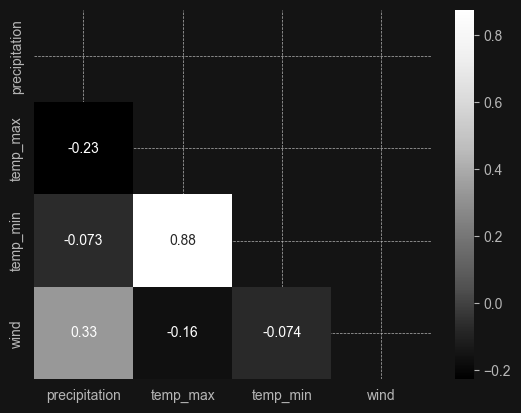

In [11]:
corr = df.drop(['weather'], axis=1).corr()
sb.heatmap(corr, annot=True, cmap='Greys_r', mask=np.triu(np.ones(len(corr)), k=0))

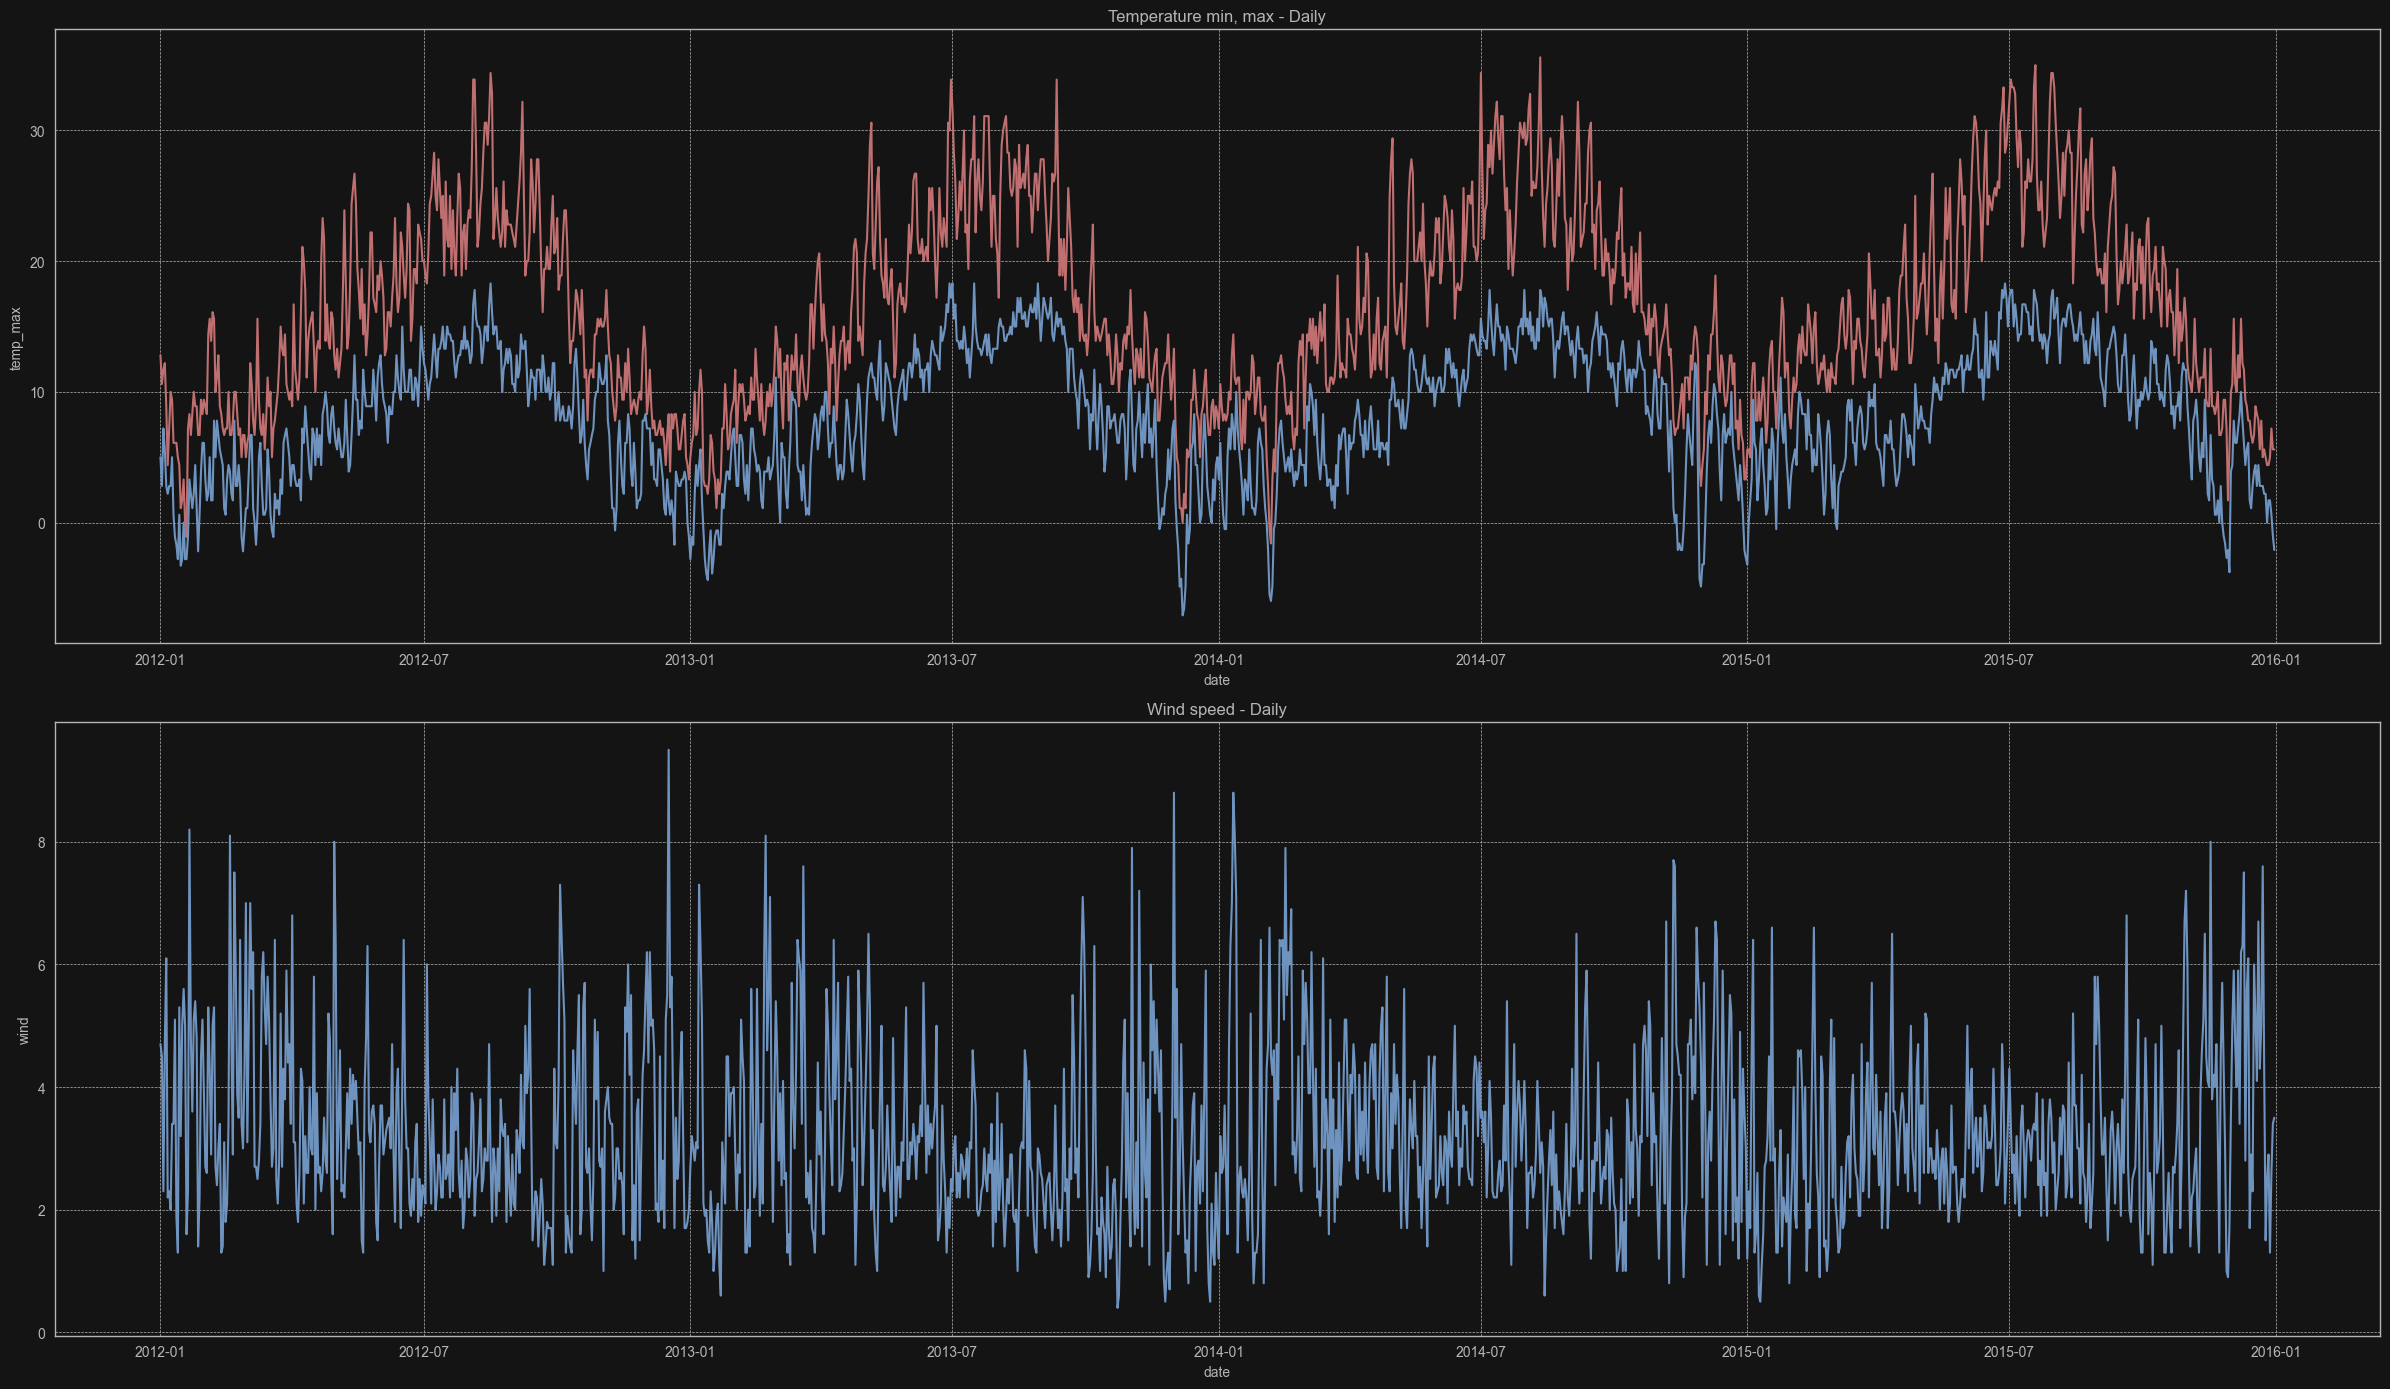

In [12]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(24, 14))
axes = axes.flatten()

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

sb.lineplot(data=df, x='date', y='temp_max', color=mid_red, ax=axes[0])
sb.lineplot(data=df, x='date', y='temp_min', color=mid_blue, ax=axes[0])
sb.lineplot(data=df, x='date', y='wind', color=mid_blue, ax=axes[1])

axes[0].set_title('Temperature min, max - Daily')
axes[1].set_title('Wind speed - Daily')

plt.tight_layout()

Since both temp_min and temp_max change almost the same way, and we don't have timestamps of each hour per day. We can extract _**average temperature**_ that day. <br>
This can reduce the number of values for the model to calculate and change the input size by removing redundant features.

In [13]:
temp_avg = (df['temp_max'] + df['temp_min']) / 2
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df.insert(1, 'temp_avg', temp_avg)
df

,precipitation,temp_avg,wind,weather
date,,,,
2012-01-01,0.0,8.90,4.7,drizzle
2012-01-02,10.9,6.70,4.5,rain
2012-01-03,0.8,9.45,2.3,rain
2012-01-04,20.3,8.90,4.7,rain
2012-01-05,1.3,5.85,6.1,rain
...,...,...,...,...
2015-12-27,8.6,3.05,2.9,rain
2015-12-28,1.5,3.35,1.3,rain
2015-12-29,0.0,3.90,2.6,fog


I've created 3 time resampled versions of the same dataframe so the plot is easier to read.

In [14]:
df_daily = df.drop('weather', axis=1).resample('D').mean()
df_weekly = df.drop('weather', axis=1).resample('W').mean()
df_monthly = df.drop('weather', axis=1).resample('ME').mean()
df_monthly.head()

,precipitation,temp_avg,wind
date,,,
2012-01-31,5.590323,4.298387,3.900000
2012-02-29,3.182759,6.239655,3.903448
2012-03-31,5.903226,6.196774,4.248387
2012-04-30,2.270000,10.433333,3.373333
2012-05-31,1.683871,12.925806,3.354839


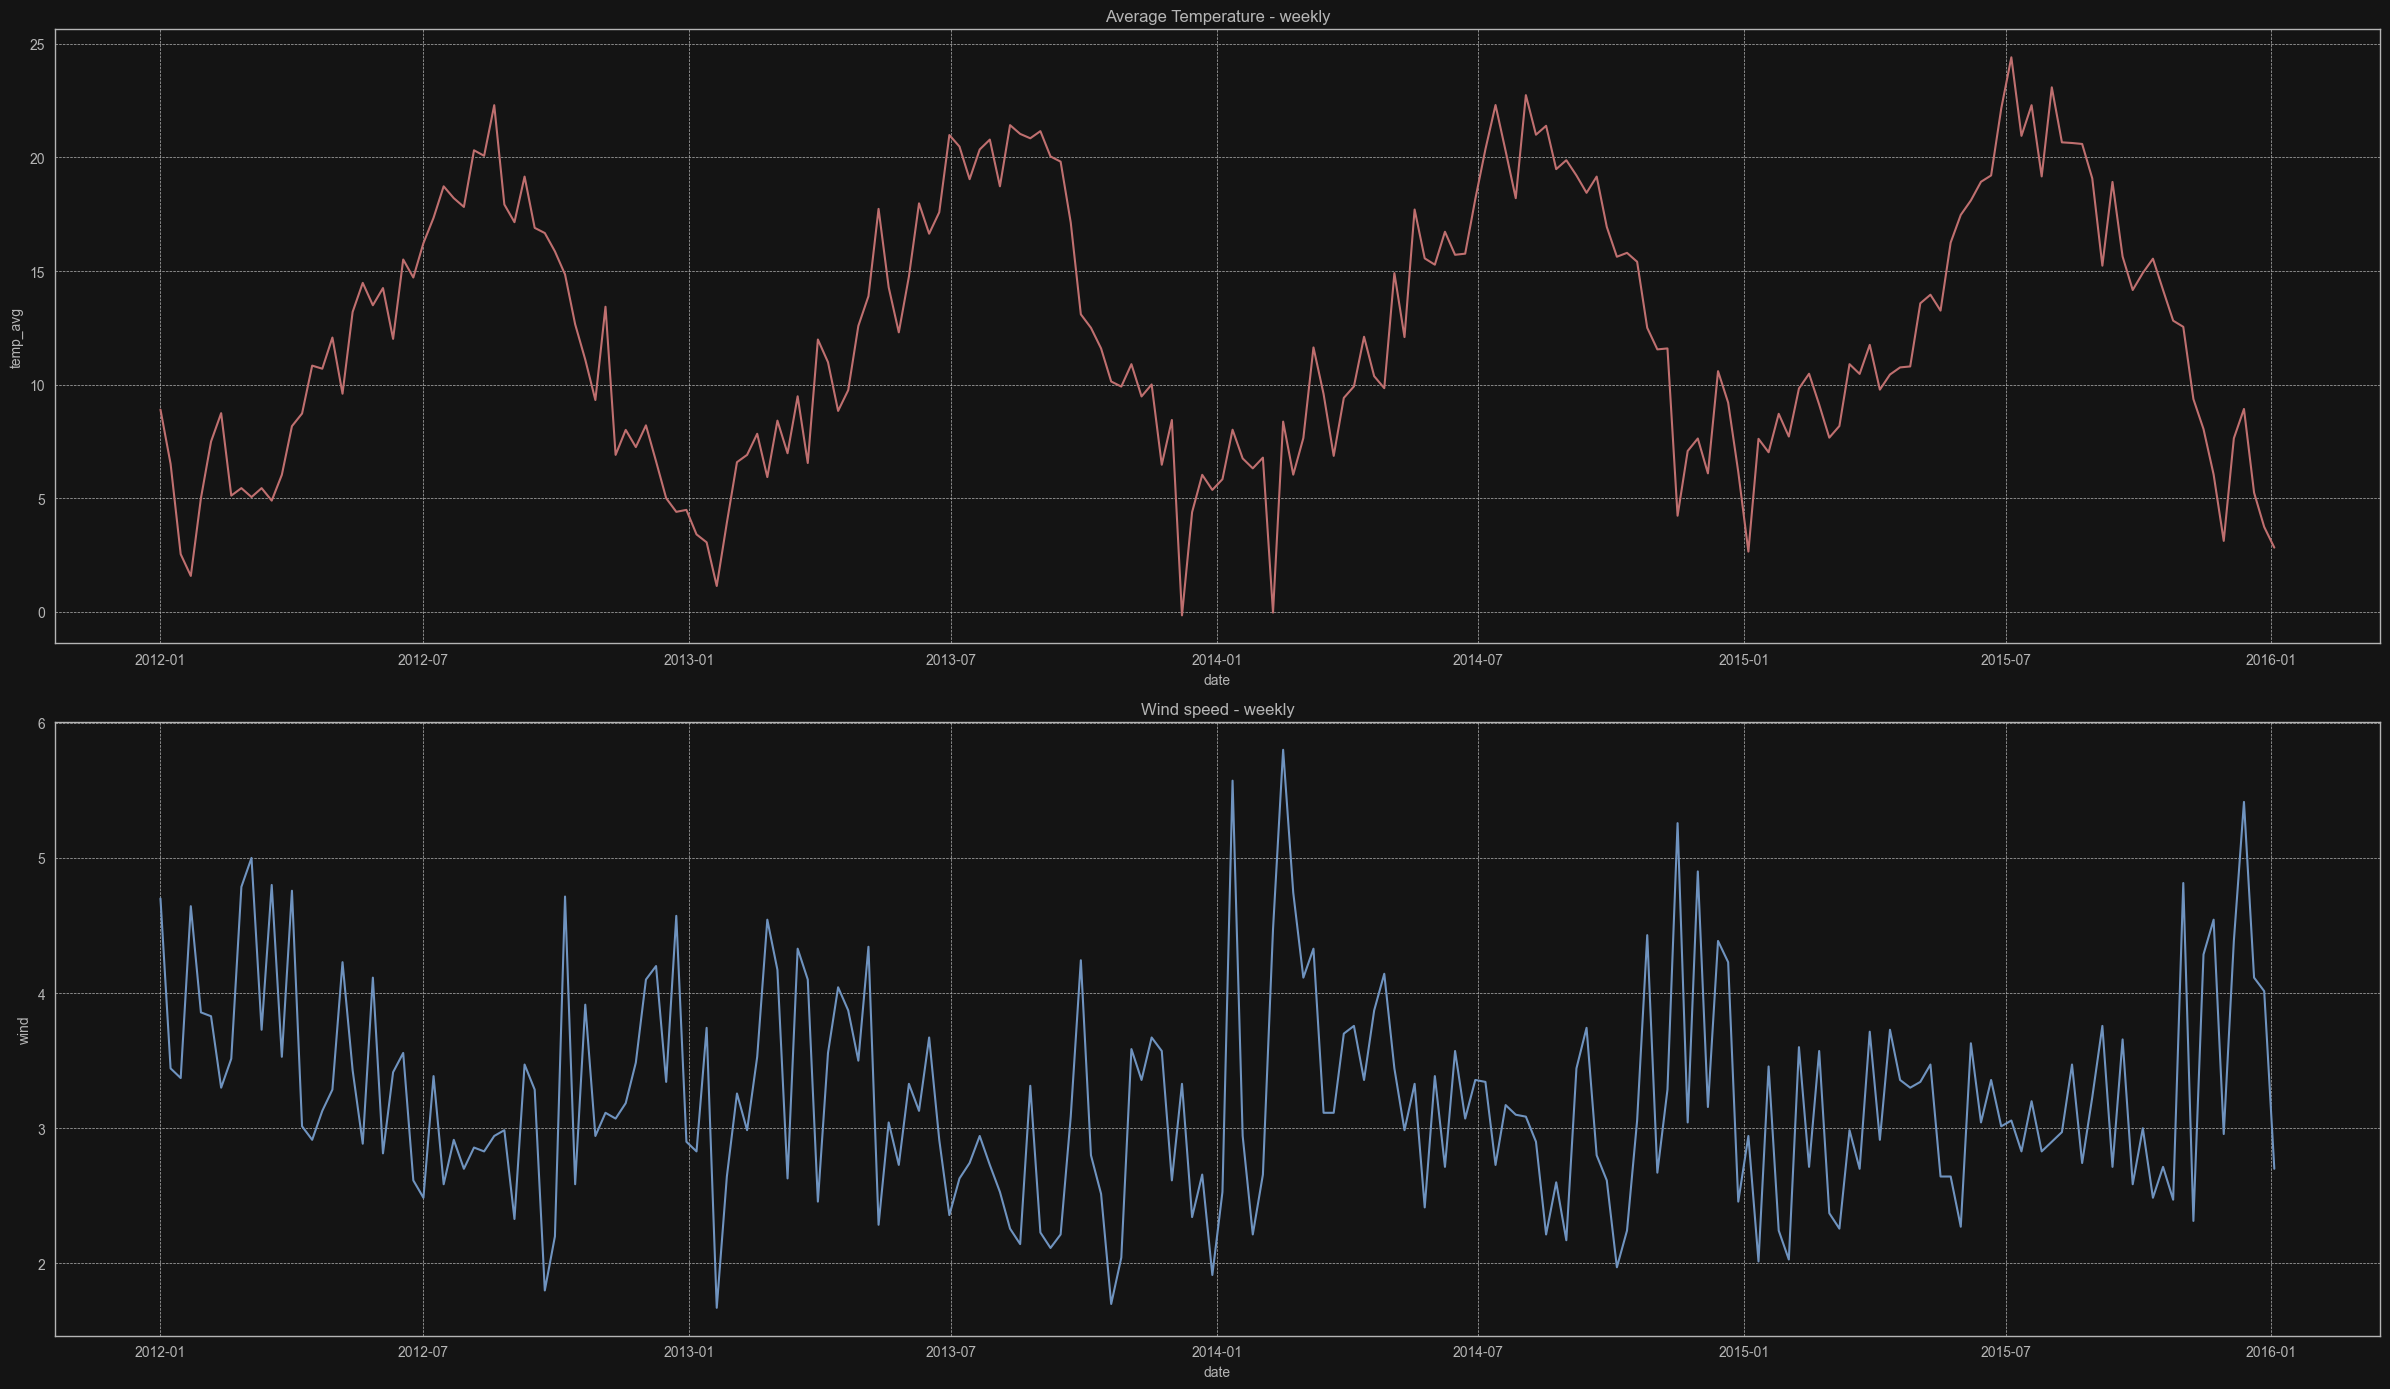

In [15]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(24, 14))
axes = axes.flatten()

sb.lineplot(data=df_weekly, x='date', y='temp_avg', color=mid_red, ax=axes[0])
sb.lineplot(data=df_weekly, x='date', y='wind', color=mid_blue, ax=axes[1])

axes[0].set_title('Average Temperature - weekly')
axes[1].set_title('Wind speed - weekly')

plt.tight_layout()

<Axes: xlabel='weather', ylabel='count'>

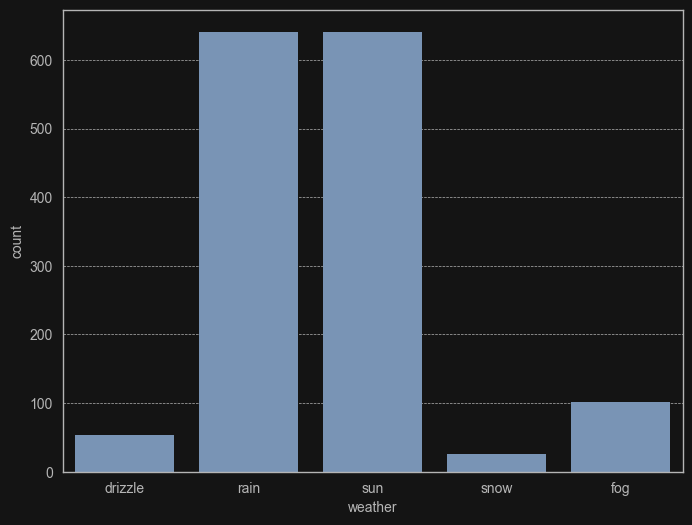

In [16]:
fig = plt.figure(figsize=(8, 6))

sb.countplot(data=df, x='weather', color=mid_blue, edgecolor='none')

#### 1.4 Preparing data for model
First we have to convert our weather condition labels to actual numeric values, <br>
because the RNN model classification expect labels with dtype of integer. <br>
For this I'm going to use simple dictionaries.

In [17]:
weather_to_idx = {
    k: v for v, k in enumerate(df['weather'].unique())
}
idx_to_weather = {
    k: v for k, v in enumerate(df['weather'].unique())
}
weather_to_idx

{'drizzle': 0, 'rain': 1, 'sun': 2, 'snow': 3, 'fog': 4}

Just making sure if backwards conversion is fine.

In [18]:
for w in df['weather'].unique():
    print(f"{w:>10}:", w == idx_to_weather[weather_to_idx[w]])

   drizzle: True
      rain: True
       sun: True
      snow: True
       fog: True


In [19]:
df['weather'] = df['weather'].apply(lambda x: weather_to_idx[x])
df

,precipitation,temp_avg,wind,weather
date,,,,
2012-01-01,0.0,8.90,4.7,0
2012-01-02,10.9,6.70,4.5,1
2012-01-03,0.8,9.45,2.3,1
2012-01-04,20.3,8.90,4.7,1
2012-01-05,1.3,5.85,6.1,1
...,...,...,...,...
2015-12-27,8.6,3.05,2.9,1
2015-12-28,1.5,3.35,1.3,1
2015-12-29,0.0,3.90,2.6,4


We're going to pass sequenced data with length of 7 days per sequence. <br>
Knowing that, we have to make sure that our dataset is divisible by 7, <br>
we can simply cut it to the exact length of full weeks it contains.

In [20]:
n_weeks = len(df) // 7 * 7
df = df[:n_weeks]

Normalizing features using _**MinMaxScaler**_.

In [21]:
features = ['precipitation', 'temp_avg', 'wind']

for feat in features:
    print(
        f'{feat}\n',
        f'min: {df[feat].min()}',
        f'max: {df[feat].max()}',
        end='\n\n'
    )

precipitation
 min: 0.0 max: 55.9

temp_avg
 min: -3.8 max: 26.700000000000003

wind
 min: 0.4 max: 9.5



In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df.loc[:, features] = scaler.fit_transform(df[features])

In [23]:
features = ['precipitation', 'temp_avg', 'wind']

for feat in features:
    print(
        f'{feat}\n',
        f'min: {df[feat].min()}',
        f'max: {df[feat].max()}',
        end='\n\n'
    )

precipitation
 min: 0.0 max: 0.9999999999999999

temp_avg
 min: 0.0 max: 1.0

wind
 min: 0.0 max: 1.0



# II - Building model
#### 2.1 Train / test split
Splitting dataset using week stamps.

In [24]:
n_weeks = int(len(df) / 7)
n_weeks

208

In [25]:
train_size = int(n_weeks * 0.7) + 1
test_size = int(n_weeks * 0.3)

print(
    f"{f"train size":>12}: {train_size}",
    f"{f"test size":>12}: {test_size}", sep='\n'
)

  train size: 146
   test size: 62


In [26]:
df_train = df[: train_size*7]
df_test = df[train_size*7 :]

In [27]:
print(
    len(df_train) / 7,
    len(df_test) / 7, sep='\n'
)

146.0
62.0


First we convert each data split to numpy, so we're able to pass it to torch.

In [28]:
import numpy as np
import torch
import random

seed = 42

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [29]:
df_train_torch = df_train.to_numpy()
df_train_torch = torch.tensor(df_train_torch)

df_test_torch = df_test.to_numpy()
df_test_torch = torch.tensor(df_test_torch)
df_test_torch[:7]

tensor([[0.0000, 0.6984, 0.3077, 2.0000],
        [0.2093, 0.5885, 0.2967, 1.0000],
        [0.0179, 0.5803, 0.4725, 1.0000],
        [0.5725, 0.5721, 0.5055, 1.0000],
        [0.1682, 0.4967, 0.4615, 1.0000],
        [0.0733, 0.5066, 0.3077, 1.0000],
        [0.1091, 0.5344, 0.5495, 1.0000]], dtype=torch.float64)

#### 2.2 - Sequencing datasets
To predict weather conditions based on features from past 6 days, <br>
we have to reshape our data split sets to return specific sequences. <br><br>
Each sequence containing data from 7 days, where: <br>
X - precipitation, temp_avg and wind speed features from past 6 days <br>
y - same features, but we take just day 7

In [30]:
from torch.utils.data import TensorDataset, DataLoader

def sequence_dataset(dataset, batch_size):
    
    x, y = [], []
    
    for i in range(0, len(dataset) - 7):
        
        week = dataset[i: i + 7, :3] # take everything except 'weather'
        week_features = week[:6, :] # trim to 6 days
        week_target = week[-1, :] # take last day
        
        x.append(week_features)
        y.append(week_target)
        
    # covert to tensor dataset
    tensor_dataset = TensorDataset(torch.tensor(np.asarray(x)),
                                   torch.tensor(np.asarray(y)))
    
    # covert to data_loader
    data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return data_loader

In [31]:
batch_size = 4
train_loader = sequence_dataset(df_train_torch, batch_size=batch_size)
test_loader = sequence_dataset(df_test_torch, batch_size=batch_size)

In [32]:
i = 2

for batch in test_loader:
    input, target = batch
    print(input.size())
    print(target.size())
    break

torch.Size([4, 6, 3])
torch.Size([4, 3])


The shape corresponds to: <br>
&emsp;4 - batch size <br>
&emsp;6 - n days in sequence <br>
&emsp;3 - n features for single day <br><br>
Note that before I've said that sequence is 7 days but our input is now 6 days. That's because the 7th day became y/label.

In [33]:
for batch in train_loader:
    input, target = batch
    print(input[0], target[0], sep='\n')
    break

tensor([[0.0000, 0.6803, 0.2308],
        [0.0054, 0.7262, 0.1648],
        [0.0537, 0.6705, 0.2198],
        [0.0000, 0.6525, 0.2088],
        [0.0358, 0.6262, 0.1868],
        [0.1038, 0.5984, 0.6154]], dtype=torch.float64)
tensor([0.0000, 0.6164, 0.3736], dtype=torch.float64)


#### 2.3 class LSTM
With PyTorch we are able to build simple RNN with Long Short-Term Memory layers by simply attaching _nn.LSTM()_ with specific factors in it. <br>
The __init__ function first initializes the LSTM and fully connected layers. <br>
__*forward()*__ passes our input x to the rnn network then fully connects it to finally return last value from the output.

In [34]:
from torch import nn

class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=3, n_layers=2, dropout=0):
        super(WeatherRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) # take the last value
        return out

#### 2.4 Training function
So we take our train_loader and pass it to our training function. <br>
Training function iterates over batches for n_epoch times and passes sequences from these batches to our model <br>
that calculates loss by comparing calculated outputs with actual targets using Mean Squared Error function.

In [35]:
import torch.optim as optim

def train_model(model, device, train_loader, n_epochs=1, lr=0.001):
    
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        for i, batch in enumerate(train_loader):
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch + 1} / {n_epochs} finished | {total_loss/len(train_loader):.4f}")

#### 2.5 Testing function
Similar to training function. This time we run the model with no gradients calculations <br>
and iterate through batches from test_loader. <br>
Then return y true and y predicted values to compare where the model makes most mistakes.

In [36]:
def test_model(model, device, test_loader):
    total_loss = 0
    criterion = nn.MSELoss()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = (inputs.to(device).float(),
                               targets.to(device).float())

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            total_loss += loss.item()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test MSE Loss: {avg_loss:.4f}")

    return y_true, y_pred


#### 2.6 Training and Testing the RNN models

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 3
output_size = 3
hidden_size = 32
n_layers = 2
dropout = 0.5
learning_rate = 0.0001

n_epochs = 50

weather_rnn = WeatherRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers, output_size=output_size, dropout=dropout)

In [38]:
train_model(weather_rnn, device=device, train_loader=train_loader, n_epochs=n_epochs, lr=learning_rate)

Epoch 1 / 50 finished | 0.1401
Epoch 2 / 50 finished | 0.0256
Epoch 3 / 50 finished | 0.0247
Epoch 4 / 50 finished | 0.0236
Epoch 5 / 50 finished | 0.0227
Epoch 6 / 50 finished | 0.0212
Epoch 7 / 50 finished | 0.0202
Epoch 8 / 50 finished | 0.0189
Epoch 9 / 50 finished | 0.0175
Epoch 10 / 50 finished | 0.0169
Epoch 11 / 50 finished | 0.0164
Epoch 12 / 50 finished | 0.0158
Epoch 13 / 50 finished | 0.0160
Epoch 14 / 50 finished | 0.0155
Epoch 15 / 50 finished | 0.0155
Epoch 16 / 50 finished | 0.0156
Epoch 17 / 50 finished | 0.0154
Epoch 18 / 50 finished | 0.0154
Epoch 19 / 50 finished | 0.0152
Epoch 20 / 50 finished | 0.0153
Epoch 21 / 50 finished | 0.0152
Epoch 22 / 50 finished | 0.0150
Epoch 23 / 50 finished | 0.0151
Epoch 24 / 50 finished | 0.0151
Epoch 25 / 50 finished | 0.0149
Epoch 26 / 50 finished | 0.0150
Epoch 27 / 50 finished | 0.0148
Epoch 28 / 50 finished | 0.0148
Epoch 29 / 50 finished | 0.0147
Epoch 30 / 50 finished | 0.0149
Epoch 31 / 50 finished | 0.0146
Epoch 32 / 50 fin

In [39]:
y_true, y_pred = test_model(weather_rnn, device=device, test_loader=test_loader)

Test MSE Loss: 0.0167


In [40]:
precip_true = np.array(y_true)[:, 0]
precip_pred = np.array(y_pred)[:, 0]

temp_avg_true = np.array(y_true)[:, 1]
temp_avg_pred = np.array(y_pred)[:, 1]

wind_true = np.array(y_true)[:, 2]
wind_pred = np.array(y_pred)[:, 2]

Text(0.5, 1.0, 'wind predictions')

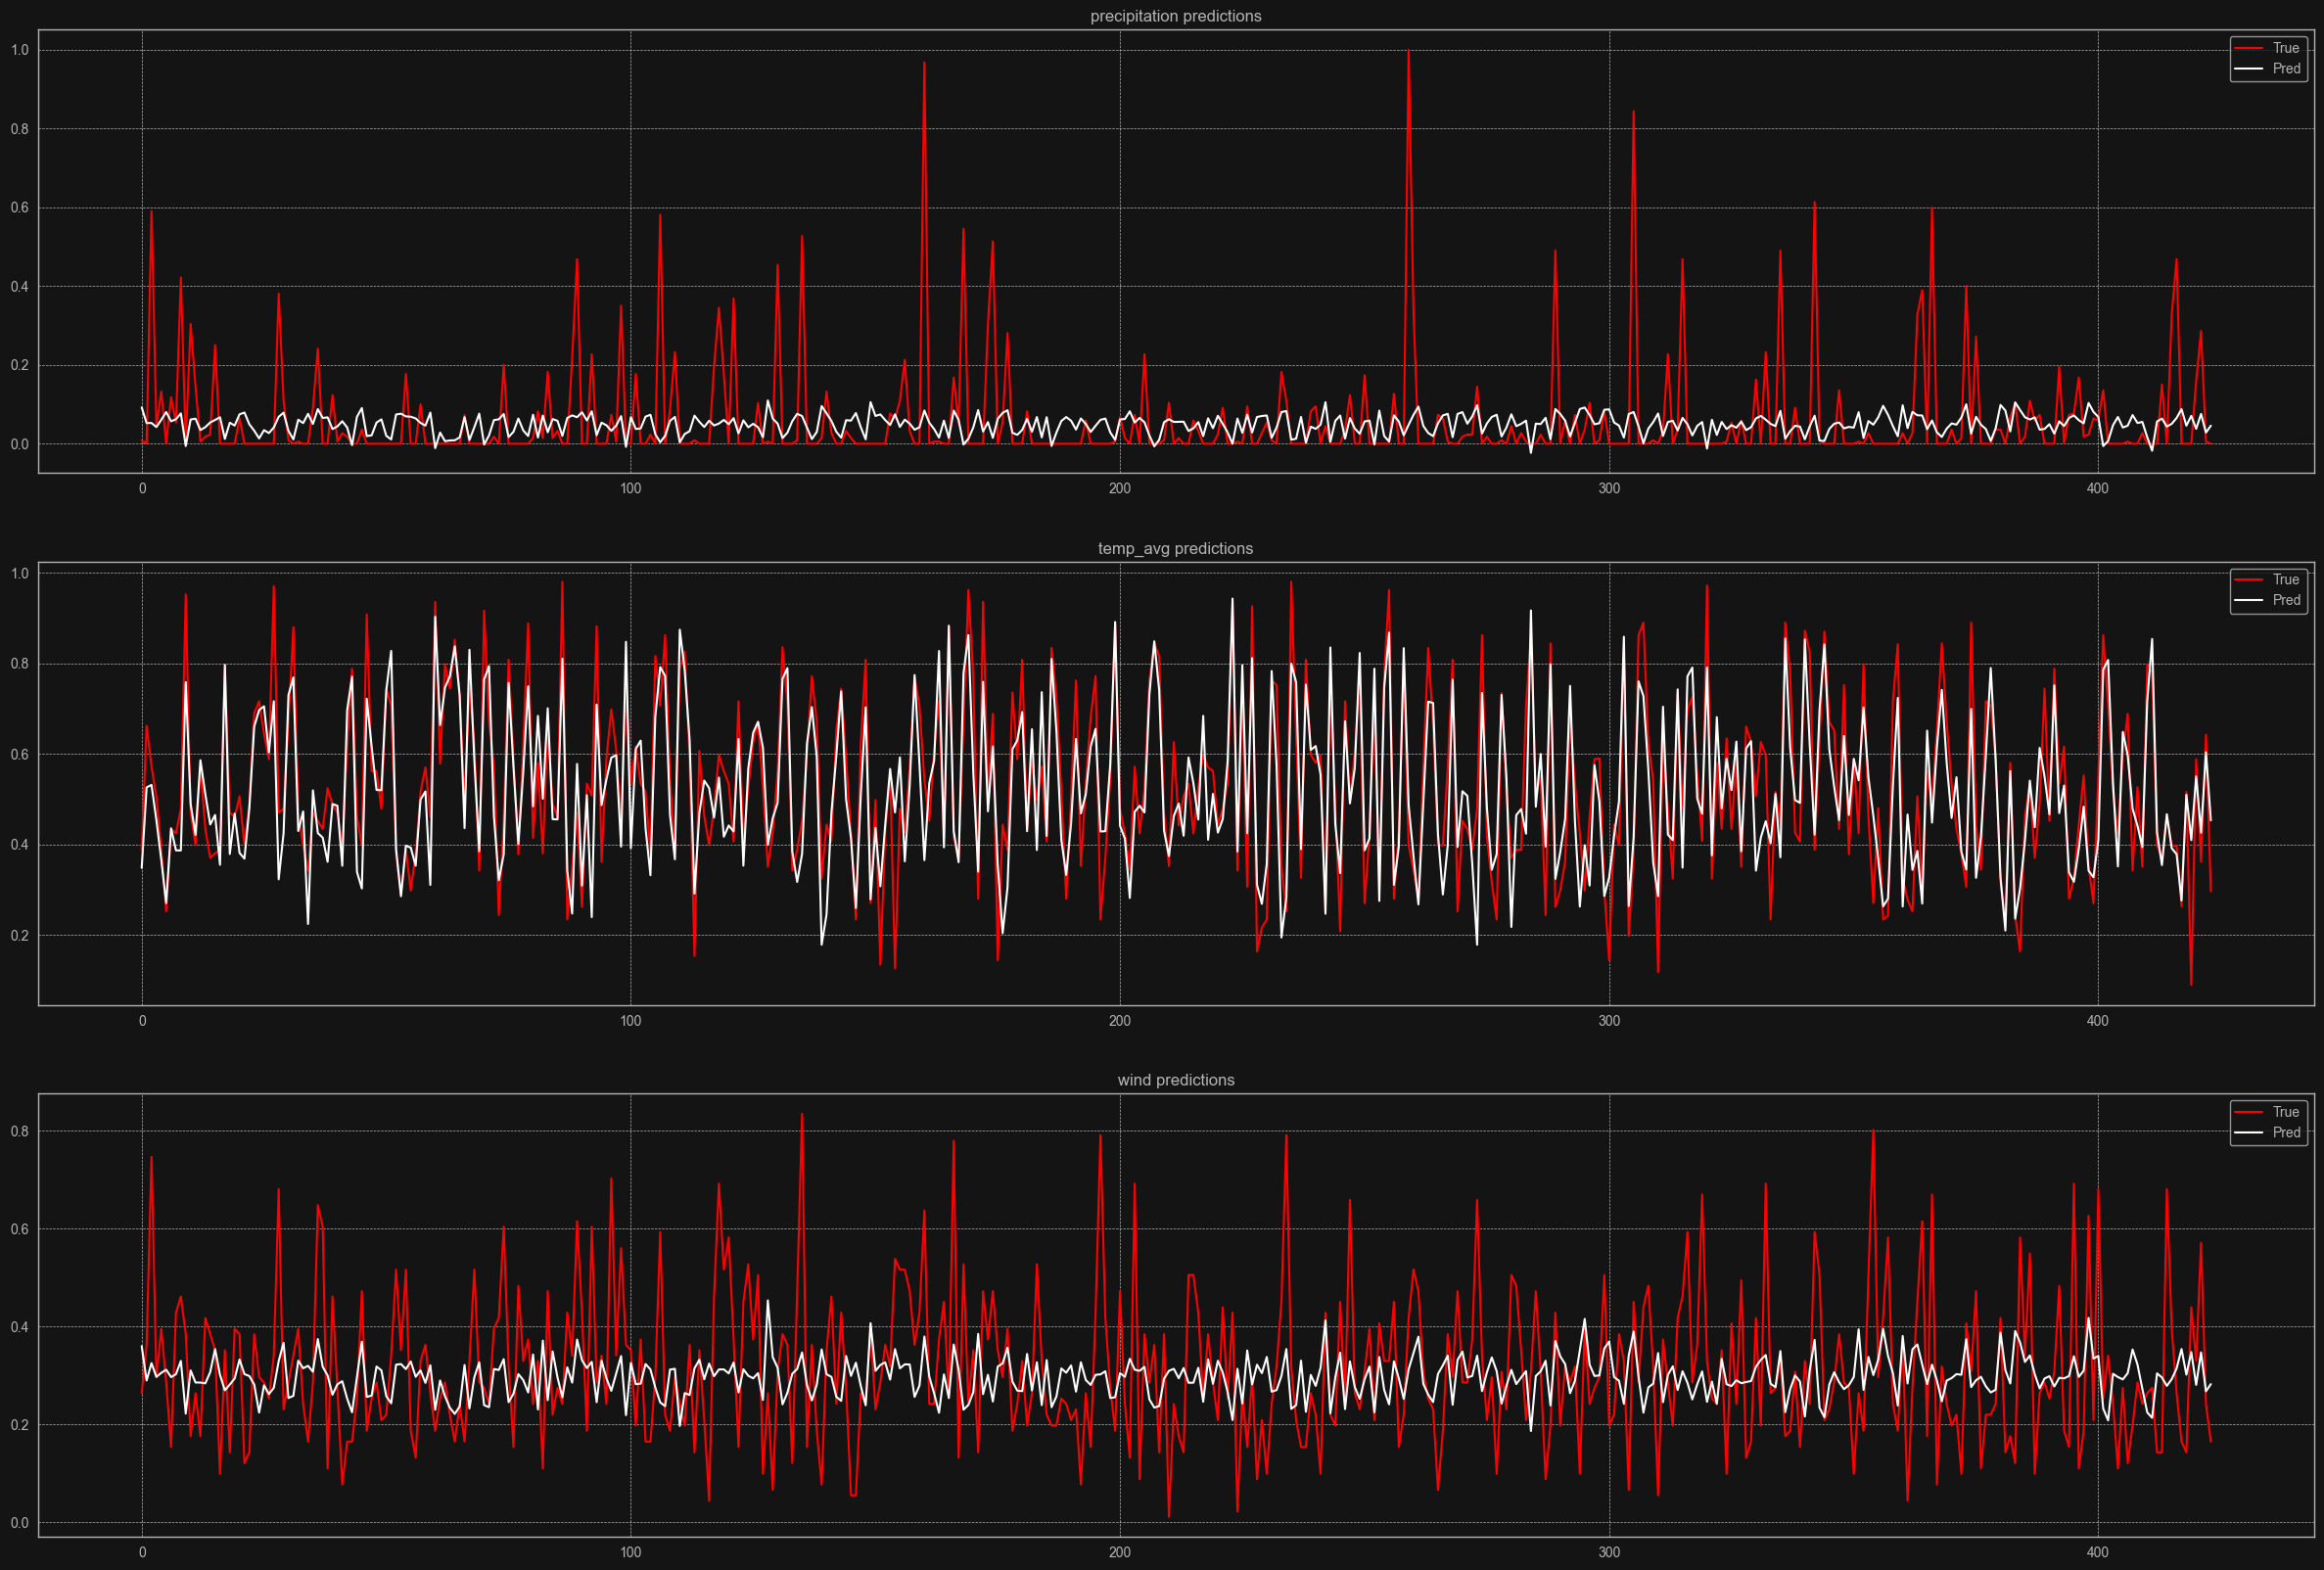

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30, 20))
axes = axes.flatten()

sb.lineplot(x=range(len(precip_true)), y=precip_true, color='red', ax=axes[0], label='True')
sb.lineplot(x=range(len(precip_pred)), y=precip_pred, color='white', ax=axes[0], label='Pred')
axes[0].set_title('precipitation predictions')

sb.lineplot(x=range(len(temp_avg_true)), y=temp_avg_true, color='red', ax=axes[1], label='True')
sb.lineplot(x=range(len(temp_avg_pred)), y=temp_avg_pred, color='white', ax=axes[1], label='Pred')
axes[1].set_title('temp_avg predictions')

sb.lineplot(x=range(len(wind_true)), y=wind_true, color='red', ax=axes[2], label='True')
sb.lineplot(x=range(len(wind_pred)), y=wind_pred, color='white', ax=axes[2], label='Pred')
axes[2].set_title('wind predictions')

# III - Conclusion
Clearly the model doesn't understand the chaos that is in the _precipitation_ and _wind_ columns. <br>
I suppose predicting such thing as weather with both high precision <br>
and large amount of features requires more than just 3 numeric columns. <br>
Despite this fact the model did decent job with predicting average temperature. <br><br>
Overall I think this project gives quiet simple fundamentals to understand the functionality of Recurrent Neural Networks.
#### Thanks for reading my project, I hope you enjoyed the process :]
_Gracjan Pawłowski 2025_